# 05. Implement a Simple AutoML System

## Top Level Design of AutoML System

我们在上个教程中，学习到了UltraOpt的设计哲学是将优化器与评价器分离，如图所示:

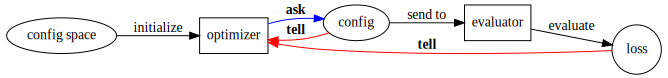

In [1]:
from graphviz import Digraph; g = Digraph()
g.node("config space", shape="ellipse"); g.node("optimizer", shape="box")
g.node("config", shape="ellipse"); g.node("loss", shape="circle"); g.node("evaluator", shape="box")
g.edge("config space", "optimizer", label="initialize"); g.edge("optimizer", "config", label="<<b>ask</b>>", color='blue')
g.edge("config","evaluator" , label="send to"); g.edge("evaluator","loss" , label="evaluate")
g.edge("config", "optimizer", label="<<b>tell</b>>", color='red'); g.edge("loss", "optimizer", label="<<b>tell</b>>", color='red')
g.graph_attr['rankdir'] = 'LR'; g

而当我们要解决AutoML问题时，我们可以这样定义AutoML系统结构：

![AutoML Structure](https://img-blog.csdnimg.cn/20201225225241790.jpg)

## Design a Simple AutoML Config Space by HDL

在`03. Conditional Parameter`教程中，我们知道了AutoML问题的优化可以视为一个CASH问题，不仅涉及算法选择，还涉及超参优化。我们用HDL定义一个简单的CASH问题的配置空间：

In [2]:
from ultraopt.hdl import hdl2cs, plot_hdl, layering_config, plot_layered_dict
HDL = {
    'classifier(choice)':{
        "LinearSVC": {
          "max_iter": {"_type": "int_quniform","_value": [300, 3000, 100], "_default": 600},
          "penalty":  {"_type": "choice", "_value": ["l1", "l2"],"_default": "l2"},
          "dual": {"_type": "choice", "_value": [True, False],"_default": False},
          "loss":  {"_type": "choice", "_value": ["hinge", "squared_hinge"],"_default": "squared_hinge"},
          "C": {"_type": "loguniform", "_value": [0.01, 10000],"_default": 1.0},
          "multi_class": "ovr",
          "random_state": 42,
          "__forbidden": [
              {"penalty": "l1","loss": "hinge"},
              {"penalty": "l2","dual": False,"loss": "hinge"},
              {"penalty": "l1","dual": False},
              {"penalty": "l1","dual": True,"loss": "squared_hinge"},
          ]
        },
        "RandomForestClassifier": {
          "n_estimators": {"_type": "int_quniform","_value": [10, 200, 10], "_default": 100},
          "criterion": {"_type": "choice","_value": ["gini", "entropy"],"_default": "gini"},
          "max_features": {"_type": "choice","_value": ["sqrt","log2"],"_default": "sqrt"},
          "min_samples_split": {"_type": "int_uniform", "_value": [2, 20],"_default": 2},
          "min_samples_leaf": {"_type": "int_uniform", "_value": [1, 20],"_default": 1},
          "bootstrap": {"_type": "choice","_value": [True, False],"_default": True},
          "random_state": 42
        },
        "KNeighborsClassifier": {
          "n_neighbors": {"_type": "int_loguniform", "_value": [1,100],"_default": 3},
          "weights" : {"_type": "choice", "_value": ["uniform", "distance"],"_default": "uniform"},
          "p": {"_type": "choice", "_value": [1, 2],"_default": 2},
        },
    }
}

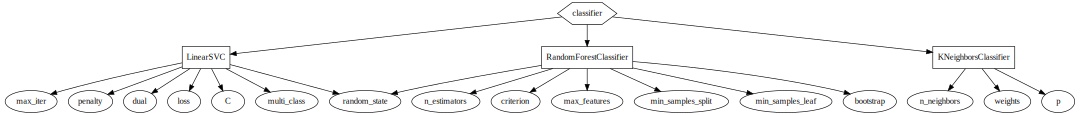

In [3]:
CS = hdl2cs(HDL)
g = plot_hdl(HDL)
g.graph_attr['size'] = "15,8"
g

## Design a Simple AutoML Evaluator

在定义好了配置空间之后，现在我们来看评价器。

在UltraOpt的设计哲学中，评价器可以是一个类（实现`__call__`魔法方法），也可以是个函数。但其必须满足：

- 接受 `dict` 类型参数 `config` 
- 返回 `float` 类型参数 `loss` 

在AutoML问题中，评价器的工作流程如下：
1. 将config转化为一个机器学习模型
2. 在训练集上对机器学习模型进行训练
3. 在验证集上得到相应的评价指标
4. 对评价指标进行处理，使其`越小越好`，返回`loss`

在了解了这些知识后，我们来开发 **AutoML 评价器**

为了方便同学们理解，我们先顺序地将之前提到的**AutoML 评价器**工作流程跑一遍：

### Step 1. 将config转化为一个机器学习模型

In [4]:
# 引入 sklearn 的分类器
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

假设评价器传入了一个 `config` 参数，我们先通过获取配置空间默认值（也可以对配置空间 `CS` 对象进行采样）得到 `config`

In [5]:
config = CS.get_default_configuration().get_dictionary()
config

{'classifier:__choice__': 'LinearSVC',
 'classifier:LinearSVC:C': 1.0,
 'classifier:LinearSVC:dual': 'True:bool',
 'classifier:LinearSVC:loss': 'squared_hinge',
 'classifier:LinearSVC:max_iter': 600,
 'classifier:LinearSVC:multi_class': 'ovr',
 'classifier:LinearSVC:penalty': 'l2',
 'classifier:LinearSVC:random_state': '42:int'}

我们用**配置分层函数** `ultraopt.hdl.layering_config` 处理这个配置

In [6]:
layered_dict = layering_config(config)
layered_dict

{'classifier': {'LinearSVC': {'C': 1.0,
   'dual': True,
   'loss': 'squared_hinge',
   'max_iter': 600,
   'multi_class': 'ovr',
   'penalty': 'l2',
   'random_state': 42}}}

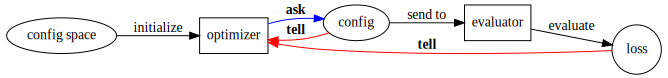

In [7]:
from graphviz import Digraph; g = Digraph()
g.node("config space", shape="ellipse"); g.node("optimizer", shape="box")
g.node("config", shape="ellipse"); g.node("loss", shape="circle"); g.node("evaluator", shape="box")
g.edge("config space", "optimizer", label="initialize"); g.edge("optimizer", "config", label="<<b>ask</b>>", color='blue')
g.edge("config","evaluator" , label="send to"); g.edge("evaluator","loss" , label="evaluate")
g.edge("config", "optimizer", label="<<b>tell</b>>", color='red'); g.edge("loss", "optimizer", label="<<b>tell</b>>", color='red')
g.graph_attr['rankdir'] = 'LR'; g

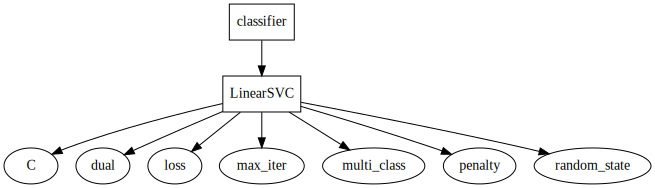

In [8]:
plot_layered_dict(layered_dict)

我们需要获取这个配置的如下信息：

- 算法选择的结果
- 被选择算法对应的参数

In [9]:
AS_HP = layered_dict['classifier'].copy()
AS, HP = AS_HP.popitem()
AS  # 算法选择的结果

'LinearSVC'

In [10]:
HP  # 被选择算法对应的参数

{'C': 1.0,
 'dual': True,
 'loss': 'squared_hinge',
 'max_iter': 600,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 42}

根据 **算法选择结果** + **对应的参数** 实例化一个 **机器学习对象**

In [11]:
ML_model = eval(AS)(**HP)
ML_model # 实例化的机器学习对象

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=600,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

### Step 2. 在训练集上对机器学习模型进行训练

我们采用MNIST手写数字数据集的一个子集来作为训练数据：

In [12]:
from sklearn.datasets import load_digits
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
X, y = load_digits(return_X_y=True)

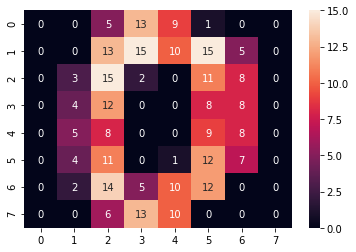

In [13]:
digit = X[0].reshape([8, 8])
sns.heatmap(digit, annot=True);

In [14]:
y[0]

0

我们需要划分一个训练集与验证集，在训练集上训练 `Step 1`得到的机器学习模型，在验证集上预测，预测值会被处理为返回的损失值 `loss` 。首先我们要对原数据进行切分以得到训练集和验证集：

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

然后我们需要在训练集`X_train`，`y_train`上对机器学习模型`ML_model`进行训练：

In [17]:
ML_model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=600,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

### Step 3. 在验证集上得到相应的评价指标

为了保证我们的机器学习模型具有对未知数据的泛化能力，所以需要用未参与训练的验证集来评价之前得到的机器学习模型。

所以，我们需要一个评价指标。这里我们选用最简单的 `accuracy_score`

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
y_pred = ML_model.predict(X_test)

In [20]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9444444444444444

我们注意到本示例的 `Step 2`与`Step 3`的训练与验证部分可能存在偏差。比如如果数据集划分得不均匀，可能会在验证集上过拟合。

我们可以用**交叉验证**(Cross Validation, CV)的方法解决这个问题，交叉验证的原理如图所示：

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=500></img>

In [21]:
from sklearn.model_selection import StratifiedKFold # 采用分层抽样
from sklearn.model_selection import cross_val_score

因为这只是一个简单的示例，所以采用3-Folds交叉验证以减少计算时间。

在实践中建议使用5-Folds交叉验证或10-Folds交叉验证。

In [22]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [23]:
scores = cross_val_score(ML_model, X, y, cv=cv)
scores

array([0.92654424, 0.94490818, 0.96327212])

我们采用交叉验证的平均值作为最后的得分：

In [24]:
score = scores.mean()
score

0.9449081803005009

### Step 4. 对评价指标进行处理，使其越小越好，返回loss

我们注意到，评价指标正确率的取值范围是0-1，且是越大越好的，所以我们需要将score处理为越小越好的loss：

In [25]:
loss = 1 - score
loss

0.055091819699499056

### 用一个函数实现AutoML评价器

In [26]:
metric = "accuracy"
def evaluate(config: dict) -> float:
    layered_dict = layering_config(config)
    display(plot_layered_dict(layered_dict))  # 用于在jupyter notebook中可视化，实践中可以删除次行
    AS_HP = layered_dict['classifier'].copy()
    AS, HP = AS_HP.popitem()
    ML_model = eval(AS)(**HP)
    # 注意到： X, y, cv, metric 都是函数外的变量
    scores = cross_val_score(ML_model, X, y, cv=cv, scoring=metric)
    score = scores.mean()
    print(f"accuracy: {score:}") # 用于在jupyter notebook中调试，实践中可以删除次行
    return 1 - score

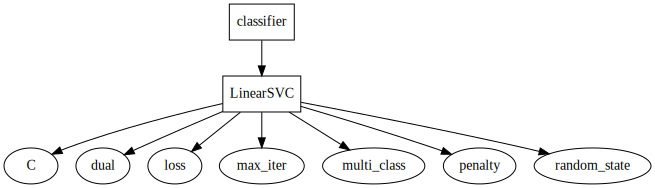

accuracy: 0.9449081803005009


0.055091819699499056

In [27]:
evaluate(CS.get_default_configuration())

### 用一个类实现AutoML评价器

我们注意到，`evaluate`函数的 X, y, cv, metric 都是函数外的变量，不利于管理，所以实践中我们一般采用定义**类**来实现评价器。

首先我们定义一个类，这个类需要根据 训练数据、评价指标和交叉验证方法 等条件进行初始化：

In [28]:
default_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

class Evaluator():
    def __init__(self, 
        X, y, 
        metric="accuracy", 
        cv=default_cv):
        # 初始化
        self.X = X
        self.y = y
        self.metric = metric
        self.cv = cv

然后我们需要实现`__call__`魔法方法，在该方法中实现整个评价过程：

In [29]:
default_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

class Evaluator():
    def __init__(self, 
        X, y, 
        metric="accuracy", 
        cv=default_cv):
        # 初始化
        self.X = X
        self.y = y
        self.metric = metric
        self.cv = cv
    
    def __call__(self, config: dict) -> float:
        layered_dict = layering_config(config)
        AS_HP = layered_dict['classifier'].copy()
        AS, HP = AS_HP.popitem()
        ML_model = eval(AS)(**HP)
        scores = cross_val_score(ML_model, self.X, self.y, cv=self.cv, scoring=self.metric)
        score = scores.mean()
        return 1 - score

实例化一个评价器对象：

In [30]:
evaluator = Evaluator(X, y)

用配置空间的一个采样样本测试这个AutoML评价器：

In [31]:
evaluator(CS.sample_configuration())

0.017250973845297835

## Implement a Simple AutoML System Based on Above Knowledge

**配置空间** 、**评价器**我们都有了，UltraOpt已经实现了成熟的**优化器**，所以我们只需要用`ultraopt.fmin`函数将这些组件串起来

In [32]:
from ultraopt import fmin

In [33]:
result = fmin(evaluator, HDL, optimizer="ETPE", n_iterations=40)
result

100%|██████████| 40/40 [00:14<00:00,  2.67trial/s, best loss: 0.012]


+----------------------------------------------------------------------------+
| HyperParameters                                     | Optimal Value        |
+-----------------------------------------------------+----------------------+
| classifier:__choice__                               | KNeighborsClassifier |
| classifier:KNeighborsClassifier:n_neighbors         | 4                    |
| classifier:KNeighborsClassifier:p                   | 2:int                |
| classifier:KNeighborsClassifier:weights             | distance             |
| classifier:LinearSVC:C                              | -                    |
| classifier:LinearSVC:dual                           | -                    |
| classifier:LinearSVC:loss                           | -                    |
| classifier:LinearSVC:max_iter                       | -                    |
| classifier:LinearSVC:multi_class                    | -                    |
| classifier:LinearSVC:penalty                      

我们可以对AutoML得到的结果进行数据分析：

首先， 我们可以绘制拟合曲线：

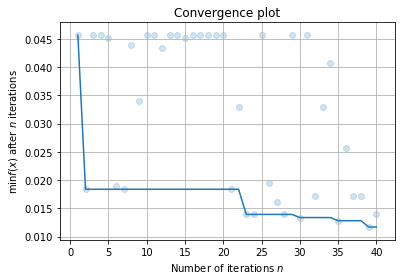

In [34]:
result.plot_convergence();

然后，我们想用`hiplot`绘制高维交互图。我们先整理出数据：

In [35]:
data = result.plot_hi(return_data_only=True, target_name="accuracy", loss2target_func=lambda loss: 1 - loss)

如果直接绘图的话，您会发现由于算法选择的存在，会导致高维交互图非常的杂乱。我们简单编写一个函数，对不同的算法选择结果的超参进行可视化：

In [36]:
import hiplot as hip

In [37]:
def viz_subset(model_name, data):
    data_filtered = []
    for datum  in data:
        if datum["classifier:__choice__"] == model_name:
            datum = datum.copy()
            score = datum.pop("accuracy")
            AS, HP = layering_config(datum)["classifier"].popitem()
            HP["accuracy"]  = score
            data_filtered.append(HP)
    hip.Experiment.from_iterable(data_filtered).display()

我们简单地对随机森林 `RandomForestClassifier` 进行可视化：

![hiplot](https://img-blog.csdnimg.cn/2020122709574745.png)

因为绘制`hiplot`高维交互图后`jupyter notebook`的文件大小会大量增加，所以我们以截图代替。您可以在自己的`notebook`中取消注释并执行以下代码：

In [40]:
#viz_subset("RandomForestClassifier", data)

In [42]:
#viz_subset("LinearSVC", data)

In [42]:
#viz_subset("KNeighborsClassifier", data)

---

我们将所有代码整理为了 `05. Implement a Simple AutoML System.py` 脚本。

您可以在这个脚本中更直接地学习一个简单AutoML系统的搭建方法。